In [1]:
import pickle
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
import collections

In [2]:
def extract_gold(file_path: str):

    with open(file_path, encoding="utf8") as f:
        datas = json.load(f)

    group_gold = {}
    datasets = datas["datasets"]

    for d in datasets:
        group_gold[d["dataset_name"]] = d["metadata"]["groups"]

    return group_gold

# Analyse et visualisation sur la répartition des groupes

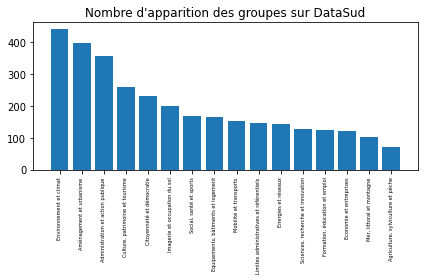

In [3]:
file_path = "../../data/datasud.json"
group_gold = extract_gold(file_path)
c = collections.Counter()
for g_value in group_gold.values():
    c.update(g_value)
c = c.most_common()

_, ax = plt.subplots()
ax.tick_params(axis="x", labelsize=5)
plt.title(f"Nombre d'apparition des groupes sur DataSud")
plt.xticks(rotation="vertical")
plt.bar([c[0] for c in c], [c[1] for c in c])
plt.tight_layout()
plt.show()

Counter({1: 861, 2: 600, 0: 258, 3: 202, 4: 69, 7: 17, 5: 14, 6: 3, 13: 2, 14: 1, 15: 1, 8: 1})


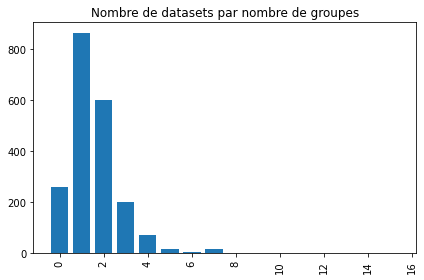

In [4]:
len_c = collections.Counter(list(map(len,group_gold.values())))

print(len_c)
_, ax = plt.subplots()
plt.title(f"Nombre de datasets par nombre de groupes")
plt.xticks(rotation="vertical")
plt.bar(len_c.keys(), len_c.values())
plt.tight_layout()
plt.show()

# Extraction des données gold et alignement avec les données prédites

In [5]:
def get_groups_len(file_path,l) :

    with open(f"{file_path}", "rb") as input_file:
        clusters = pickle.load(input_file)

    gold = []
    pred = []

    le =  preprocessing.LabelEncoder()
    all_group = list({x for l in group_gold.values() for x in l})
    le.fit(all_group)

    for dataset,groups in group_gold.items() :
        if len(groups) == l :
            gold.append(le.transform(groups)[0])
            pred.append(clusters[dataset])

    return gold,pred

# Calcul des différents scores

In [6]:
from sklearn.metrics.cluster import homogeneity_completeness_v_measure, pair_confusion_matrix, contingency_matrix
from sklearn.metrics import rand_score, fowlkes_mallows_score

def evaluate_clusters(gold,pred):
    rand = rand_score(gold,pred)
    homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(gold,pred)
    fowlkes_mallows = fowlkes_mallows_score(gold,pred)

    print(f"For {len(gold)} datas :")
    print(f"Rand index = {rand}")
    #A clustering result satisfies homogeneity if all of its clusters contain only data points which are members of a single class.
    print(f"Homogeneity = {homogeneity}") #
    #A clustering result satisfies completeness if all the data points that are members of a given class are elements of the same cluster.
    print(f"Completeness = {completeness}")
    #The V-measure is the harmonic mean between homogeneity and completeness:
    print(f"V measure = {v_measure}")
    #The Fowlkes-Mallows score FMI is defined as the geometric mean of the pairwise precision and recall
    print(f"Fowlkes-Mallows = {fowlkes_mallows}")
    pair_confusion = pair_confusion_matrix(gold,pred)
    contingency = contingency_matrix(gold, pred)
    purity = np.sum(np.amax(contingency, axis=0)) / np.sum(contingency)
    #To compute purity , each cluster is assigned to the class which is most frequent in the cluster, and then the accuracy of this assignment is measured by counting the number of correctly assigned documents and dividing by N.
    print(f"Purity = {purity}")
    sns.heatmap(pair_confusion, annot=True).set_title("Pair Confusion Matrix")

### En utilisant les contextual embedding

Agglomerative Clustering (10 clusters)
For 861 datas :
Rand index = 0.8199875752910353
Homogeneity = 0.33454653167581433
Completeness = 0.419057247127648
V measure = 0.37206328456251403
Fowlkes-Mallows = 0.3020643712061842
Purity = 0.437862950058072


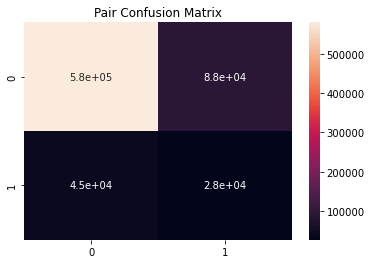

In [7]:
print("Agglomerative Clustering (10 clusters)")
group_len_1_gold, group_len_1_pred = get_groups_len("clusters/sbert_clusters_datasud_ac.pkl",1)
evaluate_clusters(group_len_1_gold,group_len_1_pred)

Agglomerative Clustering (15 clusters)
For 861 datas :
Rand index = 0.847937768414229
Homogeneity = 0.39156503172046614
Completeness = 0.4130190685391084
V measure = 0.40200601682657683
Fowlkes-Mallows = 0.2890697742564458
Purity = 0.46806039488966317


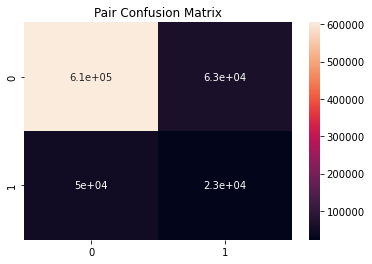

In [8]:
print("Agglomerative Clustering (15 clusters)")
group_len_1_gold, group_len_1_pred = get_groups_len("clusters/sbert_clusters_datasud_ac_15.pkl",1)
evaluate_clusters(group_len_1_gold,group_len_1_pred)

K-Means (10 clusters)
For 861 datas :
Rand index = 0.8496286092429031
Homogeneity = 0.3550519106606936
Completeness = 0.4017802685168991
V measure = 0.37697353766776787
Fowlkes-Mallows = 0.30429594987386044
Purity = 0.4518002322880372


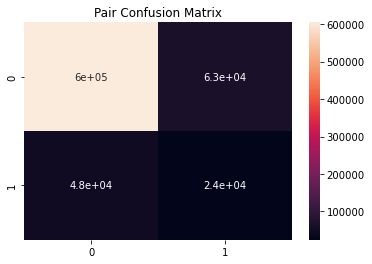

In [9]:
print("K-Means (10 clusters)")
group_len_1_gold, group_len_1_pred = get_groups_len("clusters/sbert_clusters_datasud_km.pkl",1)
evaluate_clusters(group_len_1_gold,group_len_1_pred)

K-Means (15 clusters)
For 861 datas :
Rand index = 0.871477189854955
Homogeneity = 0.400532607820042
Completeness = 0.3916258046679012
V measure = 0.3960291334674029
Fowlkes-Mallows = 0.303073172044862
Purity = 0.4994192799070848


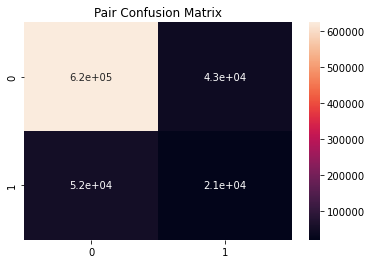

In [10]:
print("K-Means (15 clusters)")
group_len_1_gold, group_len_1_pred = get_groups_len("clusters/sbert_clusters_datasud_km_15.pkl",1)
evaluate_clusters(group_len_1_gold,group_len_1_pred)

Spectral Clustering (10 clusters)
For 861 datas :
Rand index = 0.8402641601166843
Homogeneity = 0.2674155461805462
Completeness = 0.30458344996302417
V measure = 0.28479193207875264
Fowlkes-Mallows = 0.2566578636741682
Purity = 0.40069686411149824


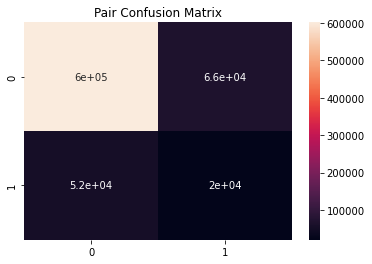

In [11]:
print("Spectral Clustering (10 clusters)")
group_len_1_gold, group_len_1_pred = get_groups_len("clusters/sbert_clusters_datasud_sc.pkl",1)
evaluate_clusters(group_len_1_gold,group_len_1_pred)

Spectral Clustering (15 clusters)
For 861 datas :
Rand index = 0.867711962833914
Homogeneity = 0.34495731225335785
Completeness = 0.3353031167090976
V measure = 0.34006170873869257
Fowlkes-Mallows = 0.2701982376512537
Purity = 0.47735191637630664


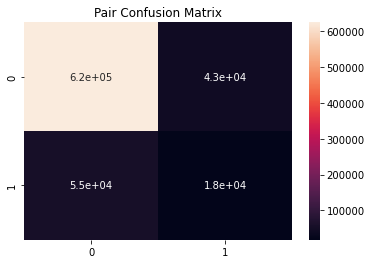

In [12]:
print("Spectral Clustering (15 clusters)")
group_len_1_gold, group_len_1_pred = get_groups_len("clusters/sbert_clusters_datasud_sc_15.pkl",1)
evaluate_clusters(group_len_1_gold,group_len_1_pred)

Affinity Propagation (251 clusters : fixed by the algo)
For 861 datas :
Rand index = 0.9062366636955406
Homogeneity = 0.8462021212544371
Completeness = 0.41521899391273476
V measure = 0.5570846868018773
Fowlkes-Mallows = 0.21686508196127324
Purity = 0.8153310104529616


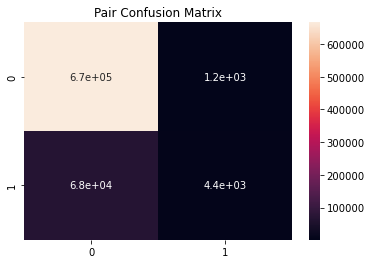

In [13]:
group_len_1_gold, group_len_1_pred = get_groups_len("clusters/sbert_clusters_datasud_ap.pkl",1)
print(f"Affinity Propagation ({max(group_len_1_pred)+1} clusters : fixed by the algo)")
evaluate_clusters(group_len_1_gold,group_len_1_pred)

### En utilisant TF-IDF

Using TF-IDF Agglomerative Clustering (10 clusters)
For 861 datas :
Rand index = 0.7562704264916403
Homogeneity = 0.26153836828308646
Completeness = 0.30499285206136106
V measure = 0.2815990716897654
Fowlkes-Mallows = 0.1828547844856671
Purity = 0.33797909407665505


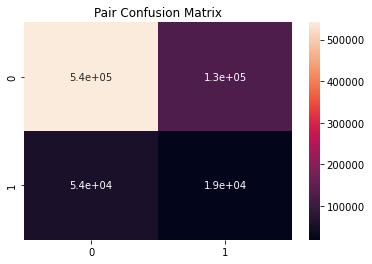

In [14]:
print("Using TF-IDF Agglomerative Clustering (10 clusters)")
group_len_1_gold, group_len_1_pred = get_groups_len("clusters/tfidf_clusters_datasud_ac_15.pkl",1)
evaluate_clusters(group_len_1_gold,group_len_1_pred)

Using TF-IDF Agglomerative Clustering (15 clusters)
For 861 datas :
Rand index = 0.7562704264916403
Homogeneity = 0.26153836828308646
Completeness = 0.30499285206136106
V measure = 0.2815990716897654
Fowlkes-Mallows = 0.1828547844856671
Purity = 0.33797909407665505


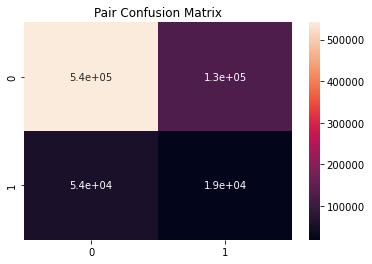

In [15]:
print("Using TF-IDF Agglomerative Clustering (15 clusters)")
group_len_1_gold, group_len_1_pred = get_groups_len("clusters/tfidf_clusters_datasud_ac_15.pkl",1)
evaluate_clusters(group_len_1_gold,group_len_1_pred)

Using TF-IDF K_Means (10 clusters)
For 861 datas :
Rand index = 0.7716554574183616
Homogeneity = 0.2194724012577966
Completeness = 0.27628129379627536
V measure = 0.2446219547207439
Fowlkes-Mallows = 0.19739984067491906
Purity = 0.313588850174216


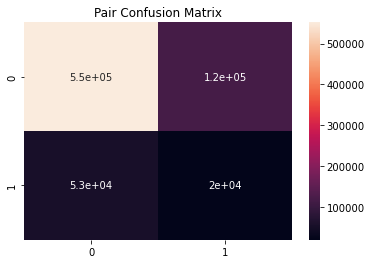

In [16]:
print("Using TF-IDF K_Means (10 clusters)")
group_len_1_gold, group_len_1_pred = get_groups_len("clusters/tfidf_clusters_datasud_km.pkl",1)
evaluate_clusters(group_len_1_gold,group_len_1_pred)

Using TF-IDF K_Means (15 clusters)
For 861 datas :
Rand index = 0.8579909785808821
Homogeneity = 0.4159774445777191
Completeness = 0.4194664975046498
V measure = 0.41771468539955503
Fowlkes-Mallows = 0.2993713740672041
Purity = 0.5040650406504065


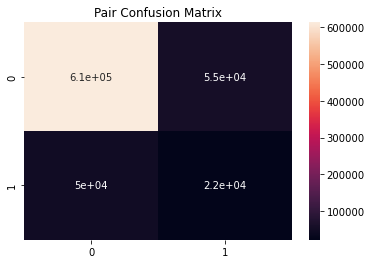

In [17]:
print("Using TF-IDF K_Means (15 clusters)")
group_len_1_gold, group_len_1_pred = get_groups_len("clusters/tfidf_clusters_datasud_km_15.pkl",1)
evaluate_clusters(group_len_1_gold,group_len_1_pred)

Using TF-IDF Spectral Clustering (10 clusters)
For 861 datas :
Rand index = 0.6701806984847257
Homogeneity = 0.19562077598873195
Completeness = 0.2892248969842438
V measure = 0.23338724850895964
Fowlkes-Mallows = 0.19545469458147396
Purity = 0.3089430894308943


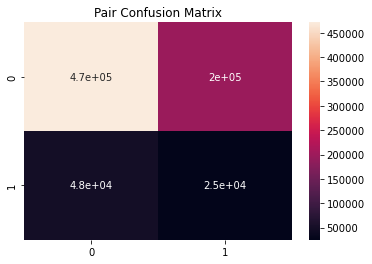

In [18]:
print("Using TF-IDF Spectral Clustering (10 clusters)")
group_len_1_gold, group_len_1_pred = get_groups_len("clusters/tfidf_clusters_datasud_sc_10.pkl",1)
evaluate_clusters(group_len_1_gold,group_len_1_pred)

Using TF-IDF Spectral Clustering (15 clusters)
For 861 datas :
Rand index = 0.7569321772951949
Homogeneity = 0.26017155315281215
Completeness = 0.304733946025779
V measure = 0.28069510440664813
Fowlkes-Mallows = 0.18083435265350437
Purity = 0.32868757259001163


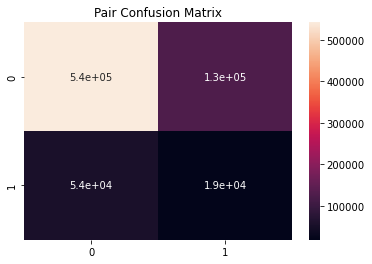

In [19]:
print("Using TF-IDF Spectral Clustering (15 clusters)")
group_len_1_gold, group_len_1_pred = get_groups_len("clusters/tfidf_clusters_datasud_sc_15.pkl",1)
evaluate_clusters(group_len_1_gold,group_len_1_pred)

Affinity Propagation (187 clusters : fixed by the algo)
For 861 datas :
Rand index = 0.8662777192555978
Homogeneity = 0.6365842366486509
Completeness = 0.38374264561056165
V measure = 0.4788357993364582
Fowlkes-Mallows = 0.1335724171907917
Purity = 0.6562137049941928


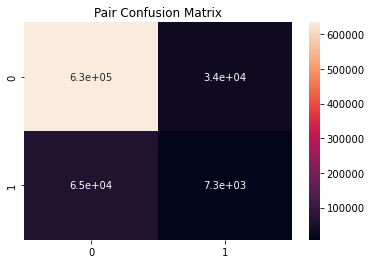

In [20]:
group_len_1_gold, group_len_1_pred = get_groups_len("clusters/tfidf_clusters_datasud_ap.pkl",1)
print(f"Affinity Propagation ({max(group_len_1_pred)+1} clusters : fixed by the algo)")
evaluate_clusters(group_len_1_gold,group_len_1_pred)

### En utilisant Word2Vec

Using Word2Vec Agglomerative Clustering (10 clusters)
For 861 datas :
Rand index = 0.8062285606244767
Homogeneity = 0.07297940383109539
Completeness = 0.08415842479019486
V measure = 0.078171268146445
Fowlkes-Mallows = 0.12032614603545001
Purity = 0.2264808362369338


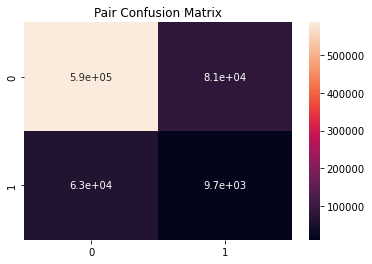

In [21]:
print("Using Word2Vec Agglomerative Clustering (10 clusters)")
group_len_1_gold, group_len_1_pred = get_groups_len("clusters/word2vec_clusters_datasud_ac_10.pkl",1)
evaluate_clusters(group_len_1_gold,group_len_1_pred)

Using Word2Vec Agglomerative Clustering (15 clusters)
For 861 datas :
Rand index = 0.8218999000621235
Homogeneity = 0.08952890952362345
Completeness = 0.09304405654515727
V measure = 0.09125264380055127
Fowlkes-Mallows = 0.12319350881027649
Purity = 0.24390243902439024


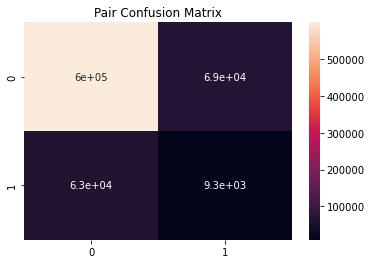

In [22]:
print("Using Word2Vec Agglomerative Clustering (15 clusters)")
group_len_1_gold, group_len_1_pred = get_groups_len("clusters/word2vec_clusters_datasud_ac_15.pkl",1)
evaluate_clusters(group_len_1_gold,group_len_1_pred)

Using Word2Vec K_Means (10 clusters)
For 861 datas :
Rand index = 0.7939470059152419
Homogeneity = 0.07201296894008506
Completeness = 0.08704658301857614
V measure = 0.07881932021141877
Fowlkes-Mallows = 0.13802544938908048
Purity = 0.22531939605110338


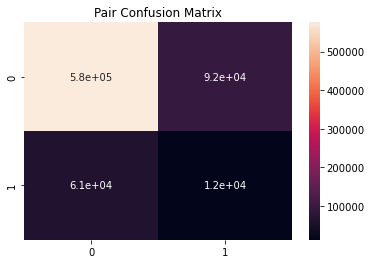

In [23]:
print("Using Word2Vec K_Means (10 clusters)")
group_len_1_gold, group_len_1_pred = get_groups_len("clusters/word2vec_clusters_datasud_km_10.pkl",1)
evaluate_clusters(group_len_1_gold,group_len_1_pred)

Using Word2Vec K_Means (15 clusters)
For 861 datas :
Rand index = 0.8240661210598816
Homogeneity = 0.08014951467071459
Completeness = 0.08308656752156826
V measure = 0.08159161838575517
Fowlkes-Mallows = 0.10982717144671511
Purity = 0.21951219512195122


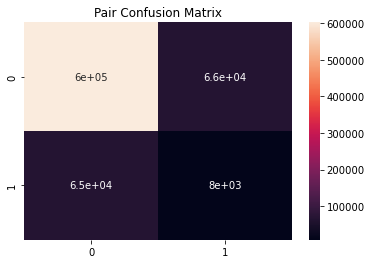

In [24]:
print("Using Word2Vec K_Means (15 clusters)")
group_len_1_gold, group_len_1_pred = get_groups_len("clusters/word2vec_clusters_datasud_km_15.pkl",1)
evaluate_clusters(group_len_1_gold,group_len_1_pred)